In [ ]:
import json
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

import add_path
import toolkit.allen_helpers.stimuli as st
import toolkit.pipeline.signal as ps
from toolkit.pipeline.data_io import SessionDirectory, FILES
from toolkit.analysis.signal import bandpass_power
from toolkit.plots.plots import plot_channel_signal_array
from toolkit.pipeline.global_settings import GLOBAL_SETTINGS
from toolkit.paths import RESULTS_DIR

pd.set_option('display.max_columns', None)

with open('config.json') as f:
    config = json.load(f)

## Get session and load data

In [2]:
session_id = config['session_id']
ecephys_structure_acronym = config['ecephys_structure_acronym']
print(f"Session ID: {session_id}")

Session ID: 721123822


In [3]:
session_dir = SessionDirectory(session_id, ecephys_structure_acronym)

probe_info = session_dir.load_probe_info()
if not session_dir.has_lfp_data:
    raise ValueError(f"Session {session_id} has no LFP data")

session = session_dir.session

/home/zc963/anaconda3/envs/allen/lib/python3.10/site-packages/hdmf/spec/namespace.py:590: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [4]:
stimulus_presentations = session.stimulus_presentations
session_type = session.session_type
drifting_gratings_stimuli = st.STIMULUS_CATEGORIES[session_type]['drifting_gratings']

In [ ]:
central_channels = probe_info['central_channels']

lfp_channels = session_dir.load_lfp_channels()
channel_positions = lfp_channels['probe_vertical_position']

csd_array = session_dir.load_csd()

bands_ds = session_dir.load_wave_bands()
preferred_orientation = session_dir.load_preferred_orientations().sel(
    layer=[GLOBAL_SETTINGS['layer_of_interest']]).values

# load bands of interest
bands_of_interest = FILES.load('bands_of_interest')

## Analyze data

In [6]:
extend_time = 1.0  # extend time at the start and end of each block to avoid boundary effect for filtering

wave_bands = bands_ds.wave_band.values

coordinates = lfp_channels['dorsal_ventral_ccf_coordinate']
if np.isnan(coordinates).any():  # if ccf coordinates are missing, use probe vertical position
    coordinates = lfp_channels['probe_vertical_position']
    coordinates_label = 'Vertical Position'
else:
    coordinates_label = 'Dorsal-Ventral CCF'

csd_plot_kwargs = dict(
    channel_positions=channel_positions,
    central_channels=central_channels,
    coordinates=coordinates,
    coordinates_label=coordinates_label
)

csd_dss = {}

### Flashes

In [7]:
stim = 'flashes'
flashes_window = (-0.2, 0.75)  # right boundary < extend_time

In [8]:
stimulus_trials = st.get_stimulus_trials(stimulus_presentations, stim)
stimulus_blocks = st.get_stimulus_blocks(stimulus_trials)

In [9]:
window = (flashes_window[0], stimulus_trials.duration + flashes_window[1])
aligned_csd = st.align_trials_from_blocks(csd_array, stimulus_blocks, window=window, ignore_nan_trials='any')[0]
average_csd = aligned_csd.mean(dim='presentation_id', keep_attrs=True)
total_power = (aligned_csd ** 2).mean(dim=('presentation_id', 'time_from_presentation_onset'))

In [10]:
freq_bands = []
for wave_band in wave_bands:
    freq_band = ps.get_band_with_highest_peak(bands_ds.sel(stimulus=stim, wave_band=wave_band))
    if freq_band is not None:
        freq_bands.append(freq_band)
freq_bands = xr.concat(freq_bands, dim='wave_band', coords=['layer'])

csd_power = {}
for wave_band in freq_bands.wave_band.values:
    block_power = bandpass_power(ps.bandpass_filter_blocks(
        csd_array, stimulus_blocks,
        freq_bands.sel(wave_band=wave_band).values,
        extend_time=extend_time,
        include_filtered=False,
        include_amplitude=True
    ))

    csd_power[wave_band] = st.align_trials_from_blocks(
        block_power, stimulus_blocks, window=window
    )[0].mean(dim='presentation_id', keep_attrs=True)
csd_power = xr.concat(csd_power.values(), dim=pd.Index(csd_power, name='wave_band'))

In [11]:
csd_dss['flashes'] = xr.Dataset(dict(
        average=average_csd,
        power=csd_power,
        total_power=total_power,
        bands=freq_bands,
        is_band_of_interest=('wave_band', np.full(freq_bands.wave_band.size, False))
    ),
    attrs=average_csd.attrs | dict(
        duration=stimulus_trials.duration,
        gap_duration=stimulus_trials.gap_duration
    )
)

### Drifting gratings CSD

In [12]:
stim = drifting_gratings_stimuli[0]  # first drifting grating stimulus
drifting_gratings_window = (-0.5, 0.5)  # right boundary < extend_time

In [13]:
stimulus_trials = st.get_stimulus_trials(stimulus_presentations, stim)
stimulus_blocks = st.get_stimulus_blocks(stimulus_trials)
conditions = st.presentation_conditions(stimulus_trials.presentations)

In [14]:
window = (drifting_gratings_window[0], stimulus_trials.duration + drifting_gratings_window[1])
aligned_csd, valid_trials = st.align_trials(
    csd_array, stimulus_trials, window=window, ignore_nan_trials='any')

if valid_trials is not None:  # if any trial is dropped by NaN values
    cond_presentation_id = st.presentation_conditions(valid_trials.presentations)[1]
    if len(conditions[1]) != len(cond_presentation_id):
        diff = set(conditions[1].keys()) - set(cond_presentation_id.keys())
        raise ValueError(f"All trials are dropped by NaN values in {stim} for conditions: {diff}")
    conditions = (conditions[0], cond_presentation_id)

# average across presentations of same condition, select conditions, average across conditions (and time)
average_csd = ps.filter_conditions(st.average_trials_with_conditions(aligned_csd, *conditions)) \
    .sel(orientation=preferred_orientation).mean(dim=st.CONDITION_TYPES, keep_attrs=True)

total_power = ps.filter_conditions(st.average_trials_with_conditions(aligned_csd ** 2, *conditions)) \
    .sel(orientation=preferred_orientation).mean(dim=(*st.CONDITION_TYPES, 'time_from_presentation_onset'))

In [15]:
freq_bands = []
is_band_of_interest = []
for wave_band in wave_bands:
    # check if wave band is already extracted from layer of interest
    is_band_of_interest_ = wave_band in bands_of_interest.wave_band and session_id in bands_of_interest.session_id
    if is_band_of_interest_:
        freq_band = bands_of_interest.sel(wave_band=wave_band, session_id=session_id)
    else:  # fallback to extract from all layers
        freq_band = ps.get_band_with_highest_peak(bands_ds.sel(stimulus=stim, wave_band=wave_band))
    if freq_band is not None:
        freq_bands.append(freq_band)
        is_band_of_interest.append(is_band_of_interest_)
freq_bands = xr.concat(freq_bands, dim='wave_band', coords=['layer'])  # also concatenate coordinate 'layer'

csd_power = {}
for wave_band in freq_bands.wave_band.values:
    block_power = bandpass_power(ps.bandpass_filter_blocks(
        csd_array, stimulus_blocks,
        freq_bands.sel(wave_band=wave_band).values,
        extend_time=extend_time,
        include_filtered=False,
        include_amplitude=True
    ))
    block_power, _ = st.align_trials(
        block_power, stimulus_trials if valid_trials is None else valid_trials,
        window=window, ignore_nan_trials=''
    )

    csd_power[wave_band] = ps.filter_conditions(st.average_trials_with_conditions(block_power, *conditions)) \
        .sel(orientation=preferred_orientation).mean(dim=st.CONDITION_TYPES, keep_attrs=True)
csd_power = xr.concat(csd_power.values(), dim=pd.Index(csd_power, name='wave_band'))

In [16]:
csd_dss['drifting_gratings'] = xr.Dataset(dict(
        average=average_csd,
        power=csd_power,
        total_power=total_power,
        bands=freq_bands,
        is_band_of_interest=('wave_band', is_band_of_interest)
    ),
    attrs=average_csd.attrs | dict(
        duration=stimulus_trials.duration,
        gap_duration=stimulus_trials.gap_duration
    )
)

### Save data

In [17]:
session_dir.save_stimulus_csd(csd_dss)

## Visualize CSDs

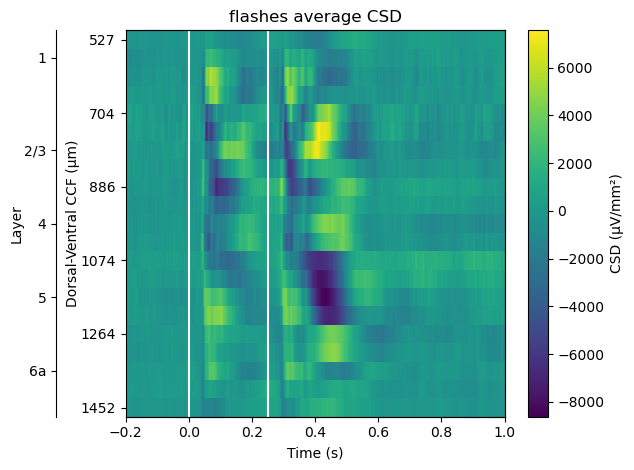

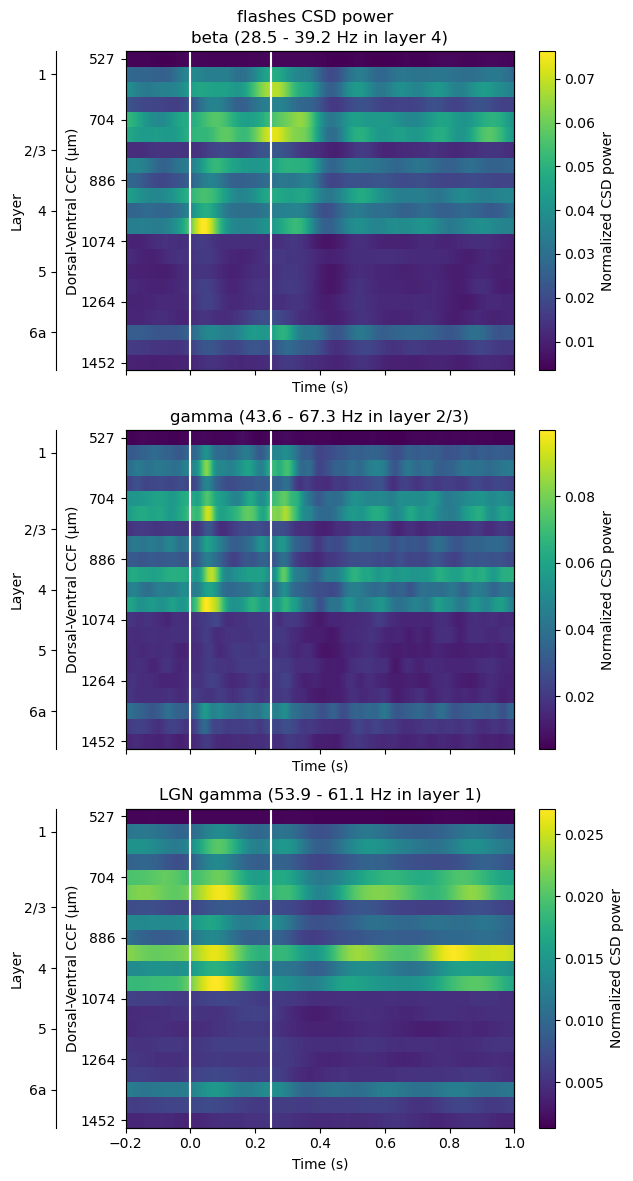

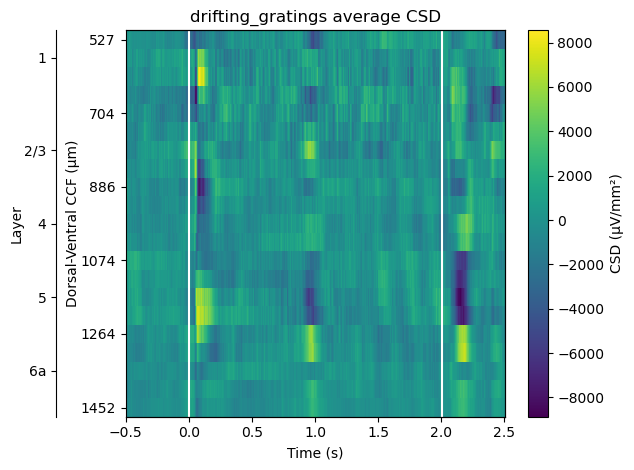

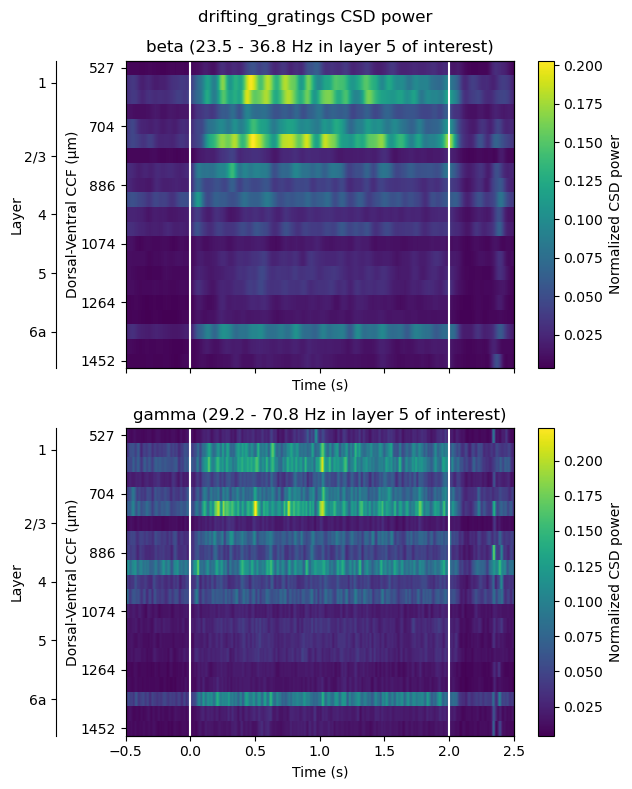

In [17]:
for stim, csd_ds in csd_dss.items():
    # average CSD
    fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8))
    plot_channel_signal_array(time=csd_ds.time_from_presentation_onset,
        signal=csd_ds.average, clabel='CSD', **csd_plot_kwargs, ax=ax)
    ax.axvline(0, color='w')
    ax.axvline(csd_ds.attrs['duration'], color='w')
    ax.set_title(f'{stim} average CSD')
    fig.tight_layout()

    # CSD power
    n_bands = csd_ds.wave_band.size
    freq_bands = csd_ds.bands

    fig, axs = plt.subplots(n_bands, 1, figsize=(6.4, 4.0 * n_bands), sharex=True, squeeze=False)
    for ax, wave_band in zip(axs.ravel(), csd_ds.wave_band.values):
        plot_channel_signal_array(
            time=csd_ds.time_from_presentation_onset,
            signal=csd_ds.power.sel(wave_band=wave_band) / csd_ds.total_power,
            clabel='Normalized CSD power', **csd_plot_kwargs, ax=ax
        )
        ax.axvline(0, color='w')
        ax.axvline(csd_ds.attrs['duration'], color='w')

        # title info
        band = csd_ds.bands.sel(wave_band=wave_band).values
        layer = csd_ds.layer.sel(wave_band=wave_band).item()
        of_interest = ' of interest' if csd_ds.is_band_of_interest.sel(wave_band=wave_band).item() else ''
        ax.set_title(f'{wave_band} ({band[0]:.1f} - {band[1]:.1f} Hz in layer {layer}{of_interest})')
    fig.suptitle(f'{stim} CSD power')
    fig.tight_layout()

plt.show()